# 1. LQR问题及解法

## 1.1 连续LQR问题
LQR（线性二次型调节器）问题是一种控制问题，通常可以用下面的数学描述
考虑一个具有动态方程的线性系统：
$$ \dot{x} = A(t)x + B(t)u \tag{1}$$
其中，$A(t)$是状态方程，$B(t)$是输入矩阵
LQR问题的**目标**是找到一个控制输入$u$, 从未能最小化一下性能指标，通常叫做成本函数或者代价函数：
$$ \begin{align}\operatorname*{arg min}_{x \in X, u \in U} J &= \operatorname*{arg min}_{x \in X, u \in U} \int_0^\infty (x^TQx + u^TRu)\text{d}t \\  \quad \text{subject to} \quad \ \dot{x}&=A(t)x+B(t)u
\end{align} \tag{2}$$
其中，$Q$为状态权重矩阵，$R$为控制输入权重矩阵，


## 1.2 离散LQR问题
以上的描述形式是针对连续系统的LQR问题描述，并且是一个无限时裕的LQR问题。考虑离散LQR问题，可以写成：
$$\begin{align} \operatorname*{arg min}_{x \in X, u \in U} J(x, u) &=\operatorname*{arg min}_{x \in X, u \in U} \sum_{k=1}^{N-1}(\frac{1}{2}x_k^TQx_k + \frac{1}{2}u_k^TRu_k) + \frac{1}{2} x_N^TQ_Nx_n \\  \quad \text{subject to} \quad x_{k+1} &= A_dx_k + B_du_k, k = 1, \ldots, N-1 \end{align}\tag{3}$$
有限时域LQR问题的**目标**是找到控制输入序列$u_1, \ldots, u_{N-1}$, 最小化（3）中的代价函数
其中，$A_d$为离散系统的状态矩阵， $B_d$为离散系统的控制矩阵
注意(3)相比(2)多了一个终端代价项。

LQR问题的代价函数
$$ J(x, u) = \sum_{k=1}^{N-1}(\frac{1}{2}x_k^TQx_k + \frac{1}{2}u_k^TRu_k) + \frac{1}{2} x_N^TQ_Nx_n $$
其中状态代价的为：$l(x_k, u_k) = \frac{1}{2}x_k^TQx_k + \frac{1}{2}u_k^TRu_k$

终端代价为：$l_f(x_N) = \frac{1}{2} x_N^TQ_Nx_n$

$Q$矩阵必须是正定的，不然系统是不可控的。问题的目标是系统回到原点（时不变LQR）或者跟踪上给定的参考轨迹（时变LQR）假设$R$不是镇定的，如$R$是零矩阵，那么控制器要做的就是把控制输入拉大无穷大，但是并不会使系统回到原定，因此问题是病态的，因此$R$必须是正定的。

- 一般地，时不变LQR用于将系统状态转移回平衡点，时变LQR用于跟随轨迹
- LQR可以用于局部近似许多非线性问题，在这些问题局部使用LQR可以取得一个不错的效果
- 有许多种LQR的扩展，如无限时域LQR，随机LQR(stochastic LQR).
- 被叫做，控制理论的皇冠明珠（It's been called the crown jewel of control theory）


# 2. Indirect/Shooting方法求解LQR问题

通过庞特里亚金极小原理（Pontryagin's Minimum Principle）。将LQR问题带入到PMP中，可以得到
$$\begin{align} x_{k+1} &= A_dx_k + B_du_k, \\
   \lambda_k &= Qx_k + A_d^T\lambda_{k+1}, \lambda_N=Qx_n \\
   u_k &= -R^{-1}B_d^T\lambda_{k+1} \end{align} \tag{4}$$

通过上面的公式可以观察到，可以通过前向rollout一条轨迹，并通过方向backtrace出来$\lambda$和 $\Delta u$。具体步骤如下：

1. 首先构造一条控制$u$的初始轨迹；
2. 根据初始状态$x_1$, 利用公式(4)中的第一个公式，前向rollout出来一条状态轨迹$x_{1:N}$;
3. 通过（4）中的第二个和第三个公式，从$N$时刻开始，backtrace出来$\lambda_{2:N}$和 $\Delta u$
4. 通过线搜索，前向模拟更新$x_{1:N}$并更新$u_{1:N-1}$
5. 进入3.中一直到$\Delta u$收敛

## 2.1 Example: Shooting Method for LQR
**系统状态方程**

下面通过python来定义一个LQR问题
这是一个二阶系统，状态方程为：
$$\dot{x} = \begin{bmatrix}\dot{q} \\ \ddot{q} \end{bmatrix} = \begin{bmatrix} 0 & 1 \\ 0 & 0 \end{bmatrix} \begin{bmatrix} q \\ \dot{q} \end{bmatrix} + \begin{bmatrix} 0 \\ 1 \end{bmatrix}u \tag{5}$$
可以将系统精确离散化，得到
$$ x_{k+1} = A_dx_k + B_du_k \tag{6}$$
其中，$A_d=\begin{bmatrix}1 & h \\ 0 & 1\end{bmatrix}$, $B_d=\begin{bmatrix} \frac{1}{2}h^2 \\ h \end{bmatrix}$


下面利用Shooting方法来求解一个LQR问题。

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Discrete dynamics
h = 0.1   # time step
A = np.array([[1, h], [0.0, 1.0]])
B = np.array([0.5 * h**2, h])
n = 2     # number of state
m = 1     # number of controls
Tfinal = 5.0 # final time
N = int(Tfinal / h) + 1

x0 = [1.0, 1.0]
# Cost weights
Q = np.identity(len(x0))
R = 0.1 #Array(1.0*I(1))
Qn = 0.5*  np.identity(len(x0))

#### 定义LQR问题的代价函数

In [2]:
def J(xhist, uhist):
    cost = 0.5 * np.dot(np.dot(xhist[-1], Qn), xhist[-1])
    for i in range(len(xhist) - 1):
        cost += 0.5 * np.dot(np.dot(xhist[i], Q), xhist[i]) + 0.5 * np.dot(np.dot(uhist[i], R), uhist[i])
    return cost

#### 根据（4）中第一个公式实现rollout

In [3]:
b = 1e-2 #line search tolerance
def rollout(xhist, uhist, Ad, Bd):
    xnew = np.zeros_like(xhist)
    xnew[0] = xhist[0]
    for k in range(N - 1):
        xnew[k+1] = np.dot(Ad, xnew[k]) + np.dot(Bd, uhist[k])
    return xnew

def shooting(x0, Ad, Bd):
    iter = 0
    alpha = 1.0
    uhist = np.zeros(N - 1) # init 控制轨迹
    xhist = np.zeros((N, len(x0)))
    xhist[0] = x0
    xhist = rollout(xhist, uhist, Ad, Bd) # rollout出一条init状态轨迹
    lambda_hist = np.zeros((N,n)) # lambda 轨迹
    du=np.ones(N-1)
    while np.linalg.norm(du) > 1e-2:
        lambda_hist[-1] = np.dot(Qn, xhist[-1])
        for k in range(N-2, -1, -1):
            du[k] = - 1.0 / R * np.dot(Bd.T, lambda_hist[k+1]) - uhist[k]
            lambda_hist[k] = np.dot(Q, xhist[k]) + np.dot(Ad.T, lambda_hist[k+1])
        # forward line search to compute x
        unew = uhist + alpha * du
        xnew = rollout(xhist, unew, Ad, Bd)
        while J(xnew, unew) > J(xhist, uhist) - alpha * b * np.dot(du, du):
            alpha = 0.5 * alpha
            unew = uhist + alpha * du
            xnew=rollout(xhist, unew, Ad, Bd)
        
        uhist = unew
        xhist = xnew
        iter = iter + 1
    return xhist, uhist, iter    

In [4]:
xhist, uhist, iter = shooting(x0=x0, Ad=A, Bd=B)
print(iter)
thist = np.linspace(0, Tfinal, N)

2360


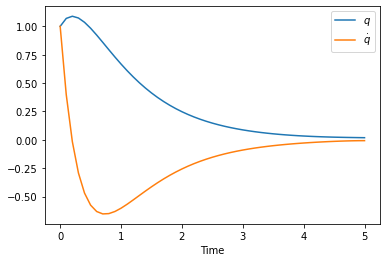

In [5]:
plt.plot(thist, xhist[:, 0], label=r'$q$')
plt.plot(thist, xhist[:, 1], label=r'$\dot{q}$')

plt.xlabel("Time")
plt.legend()


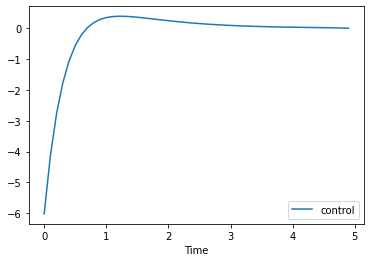

In [6]:
plt.plot(thist[0:N-1], uhist, label='control')
plt.xlabel("Time")
plt.legend()

由图可以看出来，随着时间推移，系统逐渐达到了平衡位置，此时输入的控制也达到了最小，逐渐趋近于0.

从上面的例子可以看出来，用shooting的方法求解一个LQR问题竟然循环了**2062**次。因此，shooting方法是一种相对比较低效的求解方法。这种方法也随着时代逐渐过时了。

# 3. LQR问题的QP解法

可以将LQR问题构造成QP问题求解。假设给定了初始状态（$x1$是已知的，不是决策变量）。可以将状态量，控制量堆叠起来，构造一个优化变量$z$. $z \in \mathbb{R}^{(n+m)(N-1) \times 1}$的形式如下：
$$ z = \begin{bmatrix} u_1 \\ x_2 \\ u_2 \\ x_3 \\ \vdots \\ u_{N-1} \\ x_{N} \end{bmatrix} \tag{7}$$
其中:$n$为状态维度，$m$为控制量的维度， $N$为控制horizon    
    
接着可以定义$H \in \mathbb{R}^{(n+m)(N-1) \times (n+m)(N-1)}$矩阵：
$$H = \begin{bmatrix} R & 0 & \ldots & 0 \\
                      0 & Q & \ldots & 0 \\ 
                      \vdots & \vdots & \ddots & \vdots \\
                      0 & \ldots & R & 0 \\
                      0 & \ldots & \ldots & Q_n \\
                \end{bmatrix} \tag{8}$$
                
因此，recall (3) 可以将LQR问题中代价函数写成$  J(z) =  \frac{1}{2} z^T H z $. 接着，需要改写系统状态方程，定义矩阵$C \in \mathbb{R}^{n(N-1) \times {(n+m)(N-1)}}$:
$$ C = \begin{bmatrix} B_1 & -I & \ldots & \ldots &  \ldots & \ldots & 0 \\
                        0  &  A_2 & B_2  &  -I    & \ldots & \ldots & 0 \\
                        \vdots  & \ddots & \ddots  &  \ddots   & \vdots & \vdots & \vdots \\
                        0  &  0.  &  0   &   \ldots    &  A_{N-1}    &  B_{N-1}     &   -I 
\end{bmatrix} \tag{9}$$
定义向量$d \in \mathbb{R}^{(N-1)n \times 1}$:
$$ 
d = \begin{bmatrix} -A_1x_1  \\
                 0       \\
                 \vdots  \\
                 0
\end{bmatrix}
\tag{10}
$$

因此，可以将(3)中的LQR问题可以写成：
$$ \begin{equation}
\operatorname*{arg min}_{z\in Z} \frac{1}{2}z^T H z  \\
 \quad \text{subject to} \quad Cz-d = 0
\end{equation}
\tag{11}
$$
(11)是一个QP问题 $H \geq 0$，并且只有等式约束。

(11)的拉格朗日函数可以写作：
$$ L(z, \lambda) = \frac{1}{2}z^T H z + \lambda^T (Cz - d) , \lambda \in \mathbb{R}^{n{(N-1)} \times 1} \tag{12}$$

从(12)可以得知，（11）的KKT条件为：
$$\begin{align}
Hz + C^T \lambda &= 0 \\
Cz-d &= 0
\end{align} \tag{13}$$

KKT系统可以写作：
$$\begin{bmatrix} H & C^T \\ C & 0\end{bmatrix} \begin{bmatrix}  z \\ \lambda\end{bmatrix} = \begin{bmatrix} 0 \\ d\end{bmatrix} \tag{14}$$

因此，可以解析的写出(11)的最优解，并且一定是全局最优解。

## 3.1 Example：  LQR by QP
同样求解（5）的LQR问题

[[ 1.     0.1    0.005 -1.    -0.   ]
 [ 0.     1.     0.1   -0.    -1.   ]]


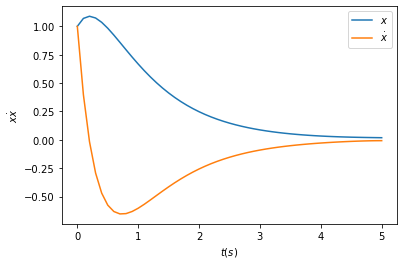

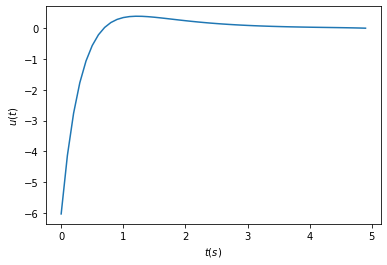

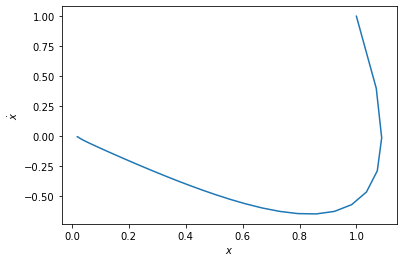

In [7]:
import numpy as np

h_size = (n + m) * (N - 1)
H = np.zeros((h_size, h_size))
# 填充对角块
block_size = len(Q) + 1  # 对角块的大小, 1为R的大小
block_matrix = np.zeros((block_size, block_size))
block_matrix[:1, :1] = R
block_matrix[1:, 1:] = Q
num_blocks =  h_size // block_size  # 块的数量
# H matrix
for i in range(num_blocks):
    H[i*block_size:(i+1)*block_size, i*block_size:(i+1)*block_size] = block_matrix
H[h_size - Qn.shape[0]: h_size, h_size - Qn.shape[1]: h_size] = Qn

c_block = np.block([A, B.reshape(-1,1), -np.eye(n)])
c_block_rows = c_block.shape[0]
c_block_cols = c_block.shape[1]
print(c_block)

C = np.zeros(((N - 1) * n, (N - 1)*(m+n)))
c_block_num = C.shape[0] // c_block_rows
col_begin = 1
for i in range(c_block_num):
    if i == 0:
        C[0:2, 0:3] = np.block([B.reshape(-1, 1), -np.eye(n)])
    else:
        row_begin = i * c_block_rows 
        row_end = row_begin+c_block_rows - 1
        col_end = col_begin + c_block_cols - 1
        C[row_begin:row_end+1, col_begin:col_end+1] = c_block
        col_begin = col_begin + n + m        

# kkt matrix
d = np.zeros((n*(N-1)))
d[0:2] = -np.dot(A, x0)
KKT = np.block([[H, C.T], [C, np.zeros((C.shape[0], C.shape[0]))]])
augment_d = np.zeros((2*n+m)*(N-1))
augment_d[(n+m)*(N-1):] = d
solve = np.dot(np.linalg.inv(KKT), augment_d)
# print(solve)
x_opt = np.zeros((N, n))
x_opt[0] = x0
u_opt = np.zeros((N-1, m))
z_opt = solve[0:(m + n)*(N-1)]
lambda_opt = solve[(m + n)*(N-1):]
z_opt_new = z_opt.reshape(-1, n+m)
for i in range(len(z_opt_new)):
    u_opt[i] = z_opt_new[i,0]
    x_opt[i+1] =z_opt_new[i][1:] 
plt.plot(thist, x_opt[:,0], label=r'$x$' )
plt.plot(thist, x_opt[:,1], label=r'$\dot{x}$' )
plt.xlabel(r'$t(s)$')
plt.ylabel(r'$x \dot{x}$')

plt.legend()
plt.show()
plt.plot(thist[:N-1], u_opt, label=r'$u$')
plt.xlabel(r'$t(s)$')
plt.ylabel(r'$u(t)$')
plt.show()

plt.plot(x_opt[:,0], x_opt[:, 1])
plt.xlabel(r'$x$')
plt.ylabel(r'$\dot{x}$')

plt.show()
        

# 4. LQR问题的Ricatti解法

在Zach的课程中，Ricatti方程是从QP问题中深入挖掘出来的，最后得到Riccati方程，不仅能得到从0到N时刻的状态值，也能得到0-N时刻的控制输入，重要的是，得到了一个反馈控制率。
我们不按照Zach的方法来推导Ricatti方程，而是从LQR问题本身出发，来一步一步推导Ricatti方程。回顾离散LQR问题（3）：
$$\begin{align} \operatorname*{arg min}_{x \in X, u \in U} J(x, u) &=\operatorname*{arg min}_{x \in X, u \in U} \sum_{k=0}^{N-1}(\frac{1}{2}x_k^TQx_k + \frac{1}{2}u_k^TRu_k) + \frac{1}{2} x_N^TQ_Nx_N \\  \quad \text{subject to} \quad x_{k+1} &= A_dx_k + B_du_k, k = 0, \ldots, N-1 \end{align}$$


在$t_N$时刻的代价为：
$$
J_{N} = \frac{1}{2} x_N^TQ_Nx_N
$$

LQR问题的目标就是找到一个控制序列$u=[u_0, u_1, \ldots, u_{N-1}]^T$, 这个控制序列使得代价函数全局最优。

在$t_{N-1}$到$t_{N}$区间的代价为
$$
 J_{N-1:N} = \frac{1}{2}(x_{N-1}^{T}Q_{N-1}x_{N-1} + u_{N-1}^{T}R_{N-1}u_{N-1}) + \frac{1}{2} {x_N^{T}} Q_Nx_N
$$

上面公式的最优解成立，根据一阶必要性条件，可以得到


$$
\frac{\partial{J_{N-1:N}}}{\partial{u_{N-1}}} = \frac{1}{2}\frac{\partial (x_{N-1}^{T}Q_{N-1}x_{N-1} + u_{N-1}^{T}R_{N-1}u_{N-1})}{\partial{u_{N-1}}} +\frac{1}{2} \frac{\partial{x_N^T Q_Nx_N }}{\partial{u_{N-1}}} = 0
$$



因此可得到：
$$ \begin{align}
& R_{N-1}u_{N-1} + \frac{1}{2} \frac{\partial x_N^TQ_Nx_N}{\partial x_N} \frac{\partial x_N}{\partial u_{N-1}}= 0 \\
& \Rightarrow R_{N-1}u_{N-1} + B^T Q_N x_N= 0 \\
& \Rightarrow B^TQ_N(Ax_{N-1} + Bu_{N-1}) + R_{N-1}u_{N-1}=0 \\
& \Rightarrow B^TQ_NAx_{N-1} = -(B^TQ_NB + R_{N-1})u_{N-1} \\
& \Rightarrow u_{N-1}^* = -(B^TQ_NB + R_{N-1})^{-1}B^TQ_NAx_{N-1} 
\end{align}
$$

令 $P_0=Q_N$ , $F_{N-1} = (B^TP_0B + R_{N-1})^{-1}B^TP_0A$, 可以将$F_{N-1}$看成反馈控制增益

因此： 
$$ \begin{align}
& u_{N-1}^* = -(B^TP_0B + R_{N-1})^{-1}B^TP_0Ax_{N-1} \\
& u^*_{N-1}=-F_{N-1}x_{N-1}
\end{align} \tag{15}$$

Hessian矩阵 $H = \frac{\partial^2 J_{N-1:N}^*}{\partial u_{N-1}^2} = R_{N-1}^T + (B^TP_0B)^T >0$ \
Hessian矩阵正定，因此是最优解


所以  $J_{N-1:N}^* = \frac{1}{2} (x_{N-1}^TQ_{N-1}x_{N-1} + x_{N-1}^TF_{N-1}^TQ_{N-1}F_{N-1}x_{N-1})$ 

令$P_1 = Q_{N-1} +F_{N-1}^TR_{N-1}F_{N-1}  + (A-F_{N-1}B)^TP_0(A-F_{N-1}B)$:
$$\begin{align} J_{N-1:N}^* &= \frac{1}{2} (x_{N-1}^TQ_{N-1}x_{N-1} + x_{N-1}^TF_{N-1}^TR_{N-1}F_{N-1}x_{N-1} + x_{N-1}^T(A-F_{N-1}B)^T P_0 (A-F_{N-1}B)x_{N-1}) \\ \Rightarrow J_{N-1:N}^* &= \frac{1}{2} x_{N-1}\left[Q_{N-1} +F_{N-1}^TR_{N-1}F_{N-1} + (A-F_{N-1}B)^TP_0(A-F_{N-1}B) \right]
 x_{N-1} \\
\Rightarrow J_{N-1:N}^* &= \frac{1}{2} x_{N-1}^TP_1x_{N-1}
\end{align}$$

$$\begin{align}
J_{N-2:N} &= J_{N-2:N-1} + J_{N-1:N} = \frac{1}{2} \left(x_{N-2}^TQ_{N-2}x_{N-2} +u_{N-2}^T R_{N-2}u_{N-2} \right) + J_{N-1:N} \\
\frac{\partial J_{N-2:N}}{\partial u_{k-2}} &= R_{N-2}u_{N-2} + B^TP_1x_{N-2} = 0
\end{align}
$$

令  $F_{N-2} = (B^T P_1 B + R_{N-2})^{-1} B^T P_1 A$
$$ \begin{align}u^*_{N-2}  &= -(B^T P_1 B + R_{N-2})^{-1} B^T P_1 A x_{N-2} \\
 u^*_{N-2}  &= -F_{N-2} x_{N-2}
 \end{align}$$

$$
J_{N-2:N}^* = \frac{1}{2}x_{N-2} \left[Q_{N-2} + F_{N-2}^TR_{N-2}F_{N-2}+(A-BF_{N-2})^T  P_{1}(A-BF_{N-2})  \right]x_{N-2}
$$

令 $P_{2} = Q_{N-2} + F_{N-2}^TR_{N-2}F_{N-2} +(A-BF_{N-2})^T  P_{1}(A-BF_{N-2}) $

可以看出来，上面是同样的迭代格式。因此总结Ricatti方程为：
$$ \begin{align}
P_0&=Q_N \\ 
F_{N-1} &= (B^TP_0B + R_{N-1})^{-1}B^TP_0A \\
P_1 &= Q_{N-1} +F_{N-1}^TR_{N-1}F_{N-1}  + (A-BF_{N-1})^TP_0(A-BF_{N-1}) \\
F_{N-2} &= (B^T P_1 B + R_{N-2})^{-1} B^T P_1 A \\
P_{2} &= Q_{N-2} + F_{N-2}^TR_{N-2}F_{N-2} +(A-BF_{N-2})^T  P_{1}(A-BF_{N-2}) \\
\vdots 
\end{align}
$$

可以用迭代的方式求解Ricatti, 得到$P_{0}$, 从而得到反馈控制率$F_{N}$

## 4.1 Ricatti方程求解LQR问题


size=77
K = [2.5856999  3.44343558]


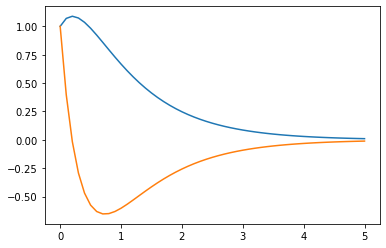

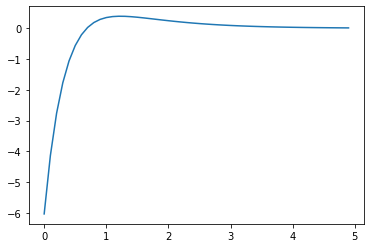

Text(0, 0.5, '$\\dot{x}$')

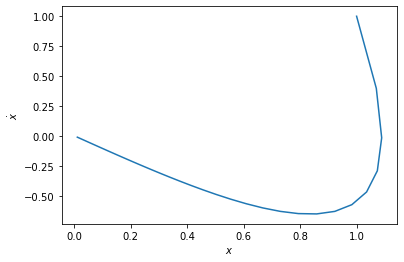

In [11]:
def ricatti_lqr(Q, R, Qn, tol=1e-6, max_iter=10000):
    P = Qn
  
    K = []
    error = 1e3
    for iter in range(max_iter):
        F = 1.0 / (R + np.dot(np.dot(B.T,P), B)).T *  np.dot(np.dot(B, P) , A)
        Pnew = Q + R * np.outer(F,F) + np.dot(np.dot((A - np.outer(B, F)).T, P), (A - np.outer(B, F)))
        K.append(F)
        error = np.linalg.norm(Pnew-P)
        P = Pnew
        if error < tol:
            break
            
    return K

feedback_gain = ricatti_lqr(Q, R, Qn)
x_hist = np.zeros((N, n))
x_hist[0] = x0
uhist = np.zeros((N-1,m))
K = feedback_gain[-1]
print('size={}'.format(len(feedback_gain)))
print('K = {}'.format(K))
for i in range(N - 1):
    uhist[i] = -np.dot(K, x_hist[i])
    x_hist[i+1] = np.dot(A, x_hist[i]) + B * uhist[i]
# print(x_hist)     
plt.plot(thist, x_hist)
plt.show()
plt.plot(thist[:N-1], uhist)
plt.show()
plt.plot(x_hist[:,0], x_hist[:, 1])
plt.xlabel(r'$x$')
plt.ylabel(r'$\dot{x}$')
   

# LQR的能控性

现在从状态空间方程出发，\
当$k=0$: $x_1 = Ax_0 + Bu_0 $ \
当$k=1$: $x_2 = Ax_1 + Bu_1 = A(Ax_0 + Bu_0) + Bu_1 = A^2x_0 + ABu_0 + Bu_1 $ \
当$k=2$: $x_3 = Ax_2 + Bu_2 = A(Ax_1 + Bu_1) + Bu_2 =   A(A^2x_0 + ABu_0 + Bu_1) + Bu_2 = A^3x_0 + A^2Bu_0 + ABu_1 + Bu_2 $ \
...\
当$k=N$: $x_N = A^Nx_0 + A^{N-1}Bu_0 + A^{N-2}Bu_1+\ldots + Bu_{N-1} $